In [1]:
import os
import torch
import esm
import pickle
import dill as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from bermol.trainer import BerMolPreTrainer
from tqdm import tqdm
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem, Crippen, Lipinski, Descriptors
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.ML.Cluster import Butina
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/home/luke/miniconda3/envs/dtiam/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cal_mol_repr(data, model_path='./models/BerMolModel_base.pkl', device='cuda'):
    with open(model_path, 'rb') as f:
        comp_model = pickle.load(f)
        comp_model.model.to(device)
        comp_model.model.eval()

    def smi_to_vec(smi):
        with torch.no_grad():
            output = comp_model.transform(smi, device)
        return output[1].cpu().detach().numpy().reshape(-1)
    
    mol_repr = {}
    mol_data = data.drop_duplicates(subset=['SMILES'])
    for _, row in tqdm(mol_data.iterrows()):
        smi = row[0]
        mol_repr[smi] = smi_to_vec(smi)
    
    return mol_repr


def cal_prot_repr(data):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    model = model.cuda()
    batch_converter = alphabet.get_batch_converter()
    model.eval()
    repr_layer = model.num_layers

    def seq_to_vecs(pid, seq, max_length=1022):
        data = [(pid, seq[:max_length]),]
        _, _, batch_tokens = batch_converter(data)
        batch_tokens = batch_tokens.to(device="cuda", non_blocking=True)
        
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[repr_layer])
        token_representations = results["representations"][repr_layer]
        sequence_representations = token_representations[0, 1:].mean(0)
        return sequence_representations.cpu().detach().numpy().reshape(-1)
    
    prot_repr = {}
    prot_data = data.drop_duplicates(subset=['Sequence'])
    for _, row in tqdm(prot_data.iterrows()):
        seq = row[0]
        prot_repr[seq] = seq_to_vecs('protein', seq)
    
    return prot_repr

def pack(data, mol_repr, prot_repr):
    representations = []
    for i in range(len(data)):
        smi, seq = data.iloc[i, :2]
        representations.append(list(mol_repr[smi]) + list(prot_repr[seq]))
    representations = pd.DataFrame(representations)
    representations['y'] = data['label']
    return representations

def prepare_data(path):
    print('prepare training data...')
    data = pd.read_csv(path + 'data.csv')

    if os.path.exists(path + 'molecular-representations.pkl'):
        mol_repr = pickle.load(open(path + 'molecular-representations.pkl', 'rb'))
    else:
        mol_repr = cal_mol_repr(data[['SMILES']])
        with open(path + 'molecular-representations.pkl', 'wb') as f:
            pickle.dump(mol_repr, f)

    if os.path.exists(path + 'protein-representations.pkl'):
        prot_repr = pickle.load(open(path + 'protein-representations.pkl', 'rb'))
    else:
        prot_repr = cal_prot_repr(data[['Sequence']])
        with open(path + 'protein-representations.pkl', 'wb') as f:
            pickle.dump(prot_repr, f)
    
    train_data = pack(data, mol_repr, prot_repr)
    return train_data

In [3]:
# training interaction model
if os.path.exists('models/interaction'):
    interaction_predictor = TabularPredictor.load("models/interaction/")

else:
    path = './data/interaction-training-data/'
    train_data = prepare_data(path)
    print('Number of training samples:', len(train_data))

    print('training...')
    interaction_predictor = TabularPredictor(label='y', verbosity=2, path='models/interaction').fit(train_data=train_data)

In [4]:
# Use interaction models to predict the probability of interaction for all molecules in the library
molecular_library = pd.read_csv('./data/molecular-library-HY-QS.csv')
print('molecular library size:', len(molecular_library))
molecular_library.head(10)

molecular library size: 10300769


,SMILES,MolWt,HBD,HBA,LogP,TPSA,RotB
0,CCn1c(SC(C)C(=O)c2ccc(C)c(C)c2)nnc1-c1ccccc1,365.502,0,5,4.94534,47.78,6
1,O=C(CN1CCN(c2ccccc2F)CC1)Nc1ccc(Cl)cc1F,365.811,1,3,3.37890,35.58,4
2,Cc1nnc2ncc(-c3cccc4c3OCC4)cn12,252.277,0,5,2.03462,52.31,1
3,CC(C)c1ccc(C2CC2C(=O)NCc2cc(=O)[nH]c(S)n2)cc1,343.452,3,4,2.60190,74.85,5
4,CCOC(=O)C[C@H](NC(=O)c1cn(Cc2ccccc2F)nn1)C(C)C,362.405,1,6,2.17310,86.11,8
5,CC(=O)N1CCCC1C(=O)NCc1csc(-c2cccs2)n1,335.454,1,5,2.49870,62.30,4
6,O=S(=O)(c1ccc2ccccc2c1)N1CCN(CCCc2ccccc2)CC1,394.540,0,3,3.77890,40.62,6
7,C=CCOC(=O)C1=C(C)N=c2s/c(=C/c3cccc(Oc4ccccc4)c...,618.667,0,10,5.56890,109.33,9
8,Cc1ccc(NC(=O)c2cccc(-c3nn[nH]n3)c2)cc1,279.303,2,4,2.42742,83.56,3
9,O=C(CCCCCn1c(=S)[nH]c2cc3c(cc2c1=O)OCO3)NCc1cc...,426.498,2,7,3.05959,98.24,8


In [5]:
if os.path.exists('./data/molecular-library-representations.pkl'):
    mol_lib_repr = pickle.load(open('./data/molecular-library-representations.pkl', 'rb'))
else:
    mol_lib_repr = cal_mol_repr(molecular_library[['SMILES']])
    with open('./data/molecular-library-representations.pkl', 'wb') as f:
        pickle.dump(mol_lib_repr, f)

TMEM16A_seq = pd.read_csv('./data/TMEM16A-Sequence.txt')
if os.path.exists('./data/TMEM16A-representations.pkl'):
    TMEM16A_prot_repr = pickle.load(open('./data/TMEM16A-representations.pkl', 'rb'))
else:
    TMEM16A_prot_repr = cal_prot_repr(TMEM16A_seq)
    with open('./data/TMEM16A-representations.pkl', 'wb') as f:
        pickle.dump(TMEM16A_prot_repr, f)

In [6]:
if os.path.exists('./results/molecular-library-interaction-prob.csv'):
    molecular_interaction_prob = pd.read_csv('./results/molecular-library-interaction-prob.csv')

else:
    molecular_data = molecular_library[['SMILES']].copy()
    molecular_data['Sequence'] = TMEM16A_seq['Sequence'][0]
    molecular_data['label'] = 0
    # molecular_data.head()

    pred_score = []
    block_n = 100000
    for i in tqdm(range(0, len(molecular_data), block_n)):
        data_block = molecular_data.iloc[i:i+block_n, :].reset_index(drop=True)
        data_pred = pack(data_block, mol_lib_repr, TMEM16A_prot_repr)
        pred_probs = interaction_predictor.predict_proba(data_pred)
        data_block['interaction_prob'] = pred_probs.iloc[:,1]
        pred_score.append(data_block)
    molecular_interaction_prob = pd.concat(pred_score)
    molecular_interaction_prob = molecular_interaction_prob.sort_values(by='interaction_prob', ascending=False)
    molecular_interaction_prob.to_csv('./results/molecular-library-interaction-prob.csv', index=None)

molecular_interaction_prob.head(10)

,SMILES,Sequence,label,interaction_prob
0,C=C1C(=O)OC2CC3(C)CCCC(=C)C3CC12,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.997581
1,CC1(C)CC[C@]2(C)CC[C@]3(C)C4=C(CC[C@@]3(C)C2C1...,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.997062
2,O=c1cc(-c2ccc(O)cc2)oc2ccc(O)cc12,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.996367
3,O=c1cc(-c2ccc(O)cc2)oc2ccc(O)cc12,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.996367
4,O=c1cc(-c2ccc(O)cc2)oc2ccc(O)cc12,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.996367
5,O=c1c(-c2ccc(O)cc2)coc2cc(O)ccc12,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.994959
6,C1=CC(=CC=C1C2=COC3=C(C2=O)C=CC(=C3)O)O,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.994959
7,O=c1c(-c2ccc(O)cc2)coc2cc(O)ccc12,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.994959
8,CC(C)=CCCC(C)C1CCC2(C)C3=C(CCC12C)C1(C)CCC(O)C...,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.994450
9,C=C1C(=O)O[C@@H]2C3OC3(C)CC/C=C(\C)CC[C@@H]12,MRVNEKYSTLPAEDRSVHIINICAIEDIGYLPSEGTLLNSLSVDPD...,0,0.993176


(array([7.433891e+06, 6.603590e+05, 3.383120e+05, 2.770030e+05,
        4.418970e+05, 7.936700e+05, 2.428670e+05, 8.442600e+04,
        2.503200e+04, 3.312000e+03]),
 array([1.52633693e-05, 9.97718733e-02, 1.99528483e-01, 2.99285093e-01,
        3.99041703e-01, 4.98798313e-01, 5.98554923e-01, 6.98311533e-01,
        7.98068143e-01, 8.97824753e-01, 9.97581363e-01]),
 <BarContainer object of 10 artists>)

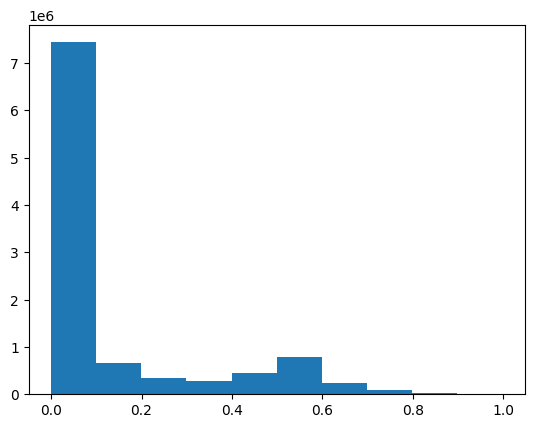

In [7]:
plt.hist(molecular_interaction_prob['interaction_prob'])

In [8]:
molecular_data_top = molecular_interaction_prob.iloc[:int(len(molecular_interaction_prob)*0.005), :]  # top 0.5% molecules
molecular_data_top = molecular_data_top.drop_duplicates(subset=['SMILES'])

In [9]:
def check_pains(smiles):
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    catalog = FilterCatalog(params)
    mol = Chem.MolFromSmiles(smiles)
    filt_re = catalog.HasMatch(mol)
    return filt_re

def filter_Lipinski(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # Check if the compound passes Lipinski's Rule of Five
    if Lipinski.NumHAcceptors(mol) <= 10 \
        and Lipinski.NumHDonors(mol) <= 5 \
        and Descriptors.MolWt(mol) <= 500 \
        and Crippen.MolLogP(mol) <= 5:
        return True
    return False

def cluster_molecules(suppl_smis, cutoff=0.4):
    mols = [Chem.MolFromSmiles(smi) for smi in suppl_smis]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols]
    # Calculate Tanimoto similarity matrix
    dists = []
    for i in tqdm(range(len(fps))):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[i+1:])
        dists.extend([1 - sim for sim in sims])

    # Perform clustering
    print('Perform clustering...')
    clusters = Butina.ClusterData(dists, len(fps), cutoff, isDistData=True)
    return clusters

def SMILES_Canonical(smiles):
    mol = Chem.MolFromSmiles(smiles)
    smi = Chem.MolToSmiles(mol)
    return smi

def drop_duplicate_mol(df):
    df['canonical_smiles'] = df['SMILES'].apply(lambda smi: SMILES_Canonical(smi))
    df = df.drop_duplicates(subset=['canonical_smiles']).reset_index(drop=True)
    return df

In [10]:
# filtered pan assay interference compounds (PAINS)
not_pains_ind = np.where([not check_pains(smiles) for smiles in tqdm(molecular_data_top['SMILES'])])
molecular_data_top_filter = molecular_data_top.iloc[not_pains_ind]
len(molecular_data_top), len(molecular_data_top_filter)

100%|██████████| 43642/43642 [31:18<00:00, 23.23it/s]


(43642, 41674)

In [11]:
# filtered the compounds by the Lipinski rules
passed_lipinski_ind = np.where([filter_Lipinski(smiles) for smiles in tqdm(molecular_data_top_filter['SMILES'])])
molecular_data_top_filter2 = molecular_data_top_filter.iloc[passed_lipinski_ind]
len(molecular_data_top_filter2), len(molecular_data_top_filter)

100%|██████████| 41674/41674 [00:24<00:00, 1703.06it/s]


(36033, 41674)

In [12]:
# clustered the molecules based on their extended-connectivity fingerprints (ECFP) similarity
clusters = cluster_molecules(molecular_data_top_filter2['SMILES'], cutoff=0.6)
len(clusters)

100%|██████████| 36033/36033 [01:39<00:00, 363.03it/s] 


Perform clustering...


3499

In [13]:
# selected representative compounds from top ranked clusters
clusters_top = []
for idx, cluster in enumerate(clusters):
    clusters_top.append(molecular_data_top_filter2.iloc[np.sort(cluster)[:1],:])
clusters_top = pd.concat(clusters_top).reset_index(drop=True)

In [14]:
# training affinity model
if os.path.exists('models/affinity'):
    affinity_predictor = TabularPredictor.load("models/affinity/")

else:
    path = './data/affinity-training-data/'
    train_data = prepare_data(path)
    print('Number of training samples:', len(train_data))

    print('training...')
    affinity_predictor = TabularPredictor(label='y', verbosity=2, path='models/affinity').fit(train_data=train_data)

In [15]:
# training mechanism model
if os.path.exists('models/mechanism'):
    mechanism_predictor = TabularPredictor.load("models/mechanism/")

else:
    path = './data/mechanism-training-data/'
    train_data = prepare_data(path)
    print('Number of training samples:', len(train_data))

    print('training...')
    mechanism_predictor = TabularPredictor(label='y', verbosity=2, path='models/mechanism').fit(train_data=train_data)

In [16]:
data_pred = pack(clusters_top[['SMILES', 'Sequence', 'label']], mol_lib_repr, TMEM16A_prot_repr)

In [17]:
# Use affinity models to predict the affinity score for the selected top ranked compounds
pred_probs = affinity_predictor.predict_proba(data_pred)
pred_probs = pred_probs.apply(lambda x: 10**(9-x) - 1)
clusters_top['affinity_score'] = pred_probs

In [18]:
# Use mechanism models to predict the inhibition probability for the selected top ranked compounds
pred_probs = mechanism_predictor.predict_proba(data_pred)
clusters_top['inhibition_prob'] = pred_probs.iloc[:,0]

In [19]:
def sort_overall(df):
    df = df[(df['interaction_prob']>0.95)&(df['affinity_score']<300)&(df['inhibition_prob']>0.95)]
    df = df.sort_values(by='interaction_prob', ascending=False)
    df = drop_duplicate_mol(df)
    return df[["SMILES", "interaction_prob", "affinity_score", "inhibition_prob"]]

In [20]:
candidate_top = sort_overall(clusters_top)
candidate_top.to_csv('./results/predicted-candidate-inhibitors-for-TMEM16A.csv', index=None)
print('Number of candidate inhibitors screened:', len(candidate_top))
candidate_top.head(30)

Number of candidate inhibitors screened: 85


,SMILES,interaction_prob,affinity_score,inhibition_prob
0,C=C1C(=O)OC2CC3(C)CCCC(=C)C3CC12,0.997581,106.070953,0.967814
1,C1=CC(=CC=C1C2=COC3=C(C2=O)C=CC(=C3)O)O,0.994959,120.638776,0.999613
2,C=C1C(=O)O[C@@H]2C3OC3(C)CC/C=C(\C)CC[C@@H]12,0.993176,110.369992,0.981951
3,CC(Cc1c[nH]c2ccc(F)cc12)NC(=O)N1C[C@@H]2[C@@H](CF)[C@@H]2C1,0.989287,279.793562,0.999773
4,CC(=O)C1CCC2C3C=CC4=CC(=O)CC[C@]4(C)C3CC[C@]12C,0.989247,63.468297,0.972873
5,CCC1=CC2Cc3nc4ccc(Cl)cc4c(N)c3C(C1)C2,0.984621,45.545446,0.998925
6,C[C@]12CCC3C(C=CC4=CC(O)CC[C@@]43C)C1CC[C@@]21CCC(=O)O1,0.984326,51.123936,0.993488
7,C=C1CC2C(CCC3(C)C(=O)CCC23)C2(C)C=CC(=O)C=C12,0.982792,124.139927,0.961373
8,NCC1(c2ccc(-c3ccc4ccc(O)cc4c3)cc2)CCCC1,0.982703,78.969090,0.999602
9,C[C@]12CCC(=O)C=C1CCC1C2=CC[C@@]2(C)C1CC[C@]2(O)C#N,0.981955,292.344950,0.968323
